In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
data_path = "./../data/yale/"

(243, 320)


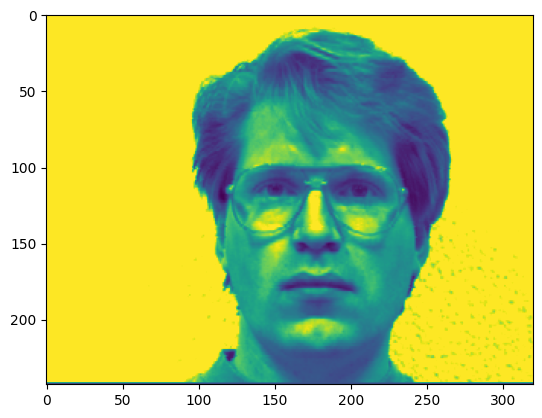

In [3]:
sample_file = data_path + "subject01.glasses"
pixels = plt.imread(sample_file,)
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(pixels.shape)
plt.imshow(pixels)
plt.show()

In [4]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

In [8]:
def extract_from_file(f):
    img = Image.open(f)
    img = img.convert('RGB')
    pixels = np.asarray(img)
    return cv2.cvtColor(pixels, cv2.COLOR_BGR2GRAY)

100%|██████████| 16/16 [00:04<00:00,  3.87it/s]


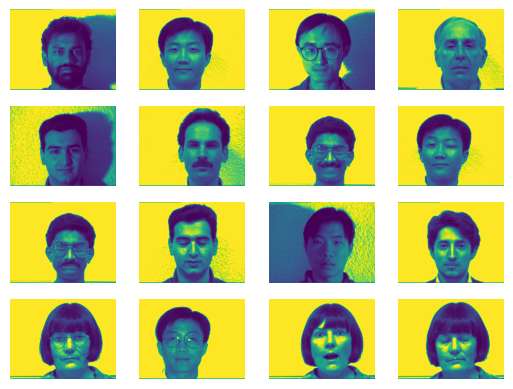

In [9]:
i = 1
DIRECTORY = './../data/yale/'
faces = list()
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    # path
    path = DIRECTORY + filename
    # get face
    face = extract_from_file(path)
    # plot
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1
plt.show()

In [12]:
files = pd.DataFrame(list_files(DIRECTORY, "subject"))

df = files[0].str.split(".", expand=True)
df['filenames'] = files
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df
df.head()

,subject,category,filenames
0,7,leftlight,subject07.leftlight
1,14,noglasses,subject14.noglasses
2,8,leftlight,subject08.leftlight
3,5,normal,subject05.normal
4,15,leftlight,subject15.leftlight


In [20]:
PER_CLASS = 8 # 11 images (3 test & 8 train)
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

# # list files for each group
# # df.groupby(['subject'])['filename'].apply(list)
y = df['subject']
X = df.drop('subject',axis=1)

# # subject
X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=45, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

In [28]:
def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filenames"]):
        path = DIRECTORY + filename
        # get face
        face = extract_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [29]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

100%|██████████| 120/120 [00:00<00:00, 371.30it/s]

(45, 243, 320)
(120, 243, 320)


In [31]:
print(len(y_train),len(y_test))

120 45


In [47]:
k = 75

X_train_col = X_train.reshape(X_train.shape[0], -1)
X_train_col = X_train_col.T
X_train_col.shape

(77760, 120)

In [50]:
X_mean = np.mean(X_train_col, axis=1)
X_mean = X_mean.reshape(-1,1)
X_mean.shape

(77760, 1)

In [51]:
X = X_train_col - X_mean

In [53]:
X_test_col = X_test.reshape(X_test.shape[0], -1)
X_test_col = X_test_col.T
X_test_centered = X_test_col - X_mean

In [57]:
L = X.T @ X
L.shape

(120, 120)

In [55]:
def pca(X, num_components):
    # TODO: Implemnt PCA
    # Compute covariance matrix
    n = X.shape[0]
    cov_matrix = np.cov(X.T) * (n-1)/n
    # Calculate the eigenvalues and eigenvectors
    eigenval, eigenvec = np.linalg.eig(cov_matrix)
    # Sort by eigenvalues and select top-k; here k = num_components
    sorted_index = np.argsort(eigenval)[::-1]
    # Project the data onto the selected eigenvectors
    eigenvec = eigenvec[:, sorted_index]
    # Return the projected data, the top-k eigenvalues and eigenvectors
    return np.dot(X, eigenvec[:, :num_components]), eigenval[sorted_index][:num_components], eigenvec[:, :num_components]

In [63]:
eigenval, eigenvec = np.linalg.eig(L)
sorted_index = np.argsort(eigenval)[::-1]
# Project the data onto the selected eigenvectors
eigenvec = eigenvec[:, sorted_index]
    # Return the projected data, the top-k eigenvalues and eigenvectors
W =eigenvec[:, :120]

In [64]:
V = X @ W

In [66]:
V.shape
for i in range(V.shape[1]):
    V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

In [81]:
k_s = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
rates = []
for i in range(len(k_s)):
    V_k = V[:, :k_s[i]]
    alpha_l = V_k.T  @ X
    alpha_p = V_k.T  @ X_test_centered
    recognized = 0
    for p in range(X_test_centered.shape[1]):
        dist = np.sum((alpha_l - alpha_p[:,p][:,np.newaxis])**2, axis=0)
        min_ind = np.argmin(dist)
        #print(y_test[p],y_train[min_ind], dist.shape)
        if y_test[p] == y_train[min_ind]:
            recognized += 1
    r = recognized/X_test_centered.shape[1]
    rates.append(r)

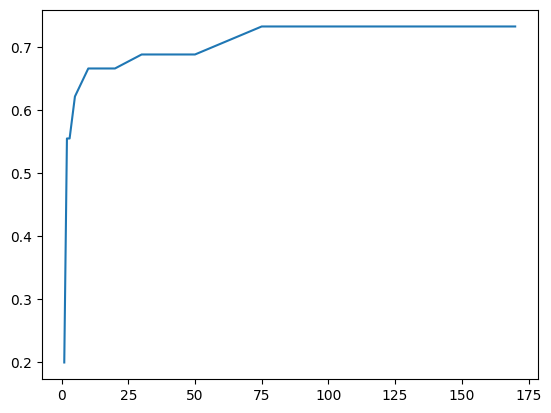

In [82]:
plt.plot(k_s, rates)